## Задача на собственные частоты голосового тракта

$$\frac{d}{dx}(S(x)\frac{d}{dx}\Psi(x)) + \lambda S(x)\Psi(x) = 0, 0 < x < L$$

$$\Psi'(0) = 0, 8\sqrt{S(L)}\Psi'(L) + 3\pi\sqrt{\pi}\Psi(L) = 0$$

$S(x)$ - площадь сечения голосового тракта

In [24]:
from BVPlib import *
from math import *
import matplotlib.pyplot as plt
from splinelib import NaturalSpline

RtoR = Callable[[float], float]
R2toR = Callable[[float, float], float]

def diff(f : RtoR, x : float):
    return (f(x + Differetiator.step) - f(x - Differetiator.step)) / (2 * Differetiator.step)

class SLPSolver:
    eps = 1e-4
    step = 1e-7

    # (S(x)y')' + lb*S(x)y = 0
    # y'(0) = 0, R(y, y') = 0
    # returns lb, (y, y')_n
    @staticmethod
    def solve_by_shooting_method(S : RtoR, R : R2toR, N: int, L : float, initial_lambda : float):
        lb = initial_lambda
        h = L/N
        def M(l : float):
            f : VecTFunc = lambda x, q: Vector(q[1], -l * q[0] - diff(S, x)/S(x) * q[1])
            fL = RungeKuttaMethods.explicit_4_order(f, Vector(1, 0), h, N, 0)[N]
            return R(fL[0], fL[1])
        while(True):
            ODEIOSettings.info("lb = " + str(lb))
            boundary = M(lb)
            if(abs(boundary) < SLPSolver.eps):
                break
            lb = lb - boundary / diff(M, lb)
        f : VecTFunc = lambda x, q: Vector(q[1], -lb * q[0] - diff(S, x)/S(x) * q[1])
        return lb, RungeKuttaMethods.explicit_4_order(f, Vector(1, 0), h, N, 0)
    
def show_result(N : int, solution : tuple[float, list[Vector | float]], L : float):
    lb, us = solution
    h = L/N
    xs = [h*k for k in range(N + 1)]
    ys = us if (isinstance(us[0], float) or isinstance(us[0], int)) else [us[k][0] for k in range(N + 1)]
    plt.plot(xs, ys)
    plt.xlabel("x, мм")
    plt.ylabel("$\\Psi$")
    plt.title(f"$\\Psi(x)$ for $f={int(sqrt(lb) * 331e3 / 2 / pi)}$ Hz")
    plt.show()

S = NaturalSpline([2.5*k for k in range(67)], 
    [78.2, 66.4, 43, 39.1, 33.2, 25.4, 31.3, 50.8, 87.7, 444, 523.2, 532.2, 538.5, 531.7, 527.2, 504.5, 498.7, 527,
    570.6, 572.5, 566.7, 549.1, 535.4, 515.9, 486.6, 453.3, 434.8, 420, 420.7, 437.2, 470.5, 480.8, 457.2, 408.4, 361.5,
    340, 295.5, 257.9, 203.2, 144.6, 103.6, 80.1, 64.5, 33.2, 21.5, 13.7, 7.8, 13.7, 23.4, 27.4, 23.4, 21.2, 18.5,
    13, 11.3, 7.2, 5.8, 5.9, 9.8, 9, 19.5, 23.4, 37.1, 52.8, 86, 139.7, 139.7])

L = 165
def R(y, dy):
    return 8*sqrt(S(L))*dy + 3*pi*sqrt(pi)*y

N = 10000
# show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 0), L)
# show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 1e-3), L)
# show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 3e-3), L)
# show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 4e-3), L)

### Метод дополненного вектора

Конечно-разностная задача:

$$
\begin{cases}
    4\Psi_1 - 3\Psi_0 - \Psi_2 = 0 \\
    S_{n+\frac{1}{2}}(\Psi_{n+1} - \Psi_n) + S_{n-\frac{1}{2}}(\Psi_{n-1} - \Psi_n) + \lambda h^2 S_n \Psi_n = 0, n = \overline{1, N-1} \\
    8\sqrt{S(L)}(3\Psi_N - 4\Psi_{N-1} + \Psi_{N-2}) + 6\pi h \sqrt{\pi}\Psi_N = 0?
\end{cases}
$$

Решение будем искать относитльно $\vec{u} = (\Psi_0, ..., \Psi_N, \lambda)^T$, используя метод Ньютона:

$$J(\vec{u})\Delta \vec{u} = - F(\vec{u})$$

В качестве $(N+1)$-го уравнения возьмём $\Psi_2 - 1 = 0 \Rightarrow \Delta u_2 = 0$


lb = 0
lb = -12.321618187044276
lb = -1.8764074864417122
lb = -0.03143582712617676
lb = 0.0070728477167960255
lb = -0.00039785483440862943
lb = 1.9584286702362976e-05
lb = 6.1640173800428486e-06
lb = 6.42625105613952e-06
lb = 6.425943971690165e-06
lb = 6.426006853207851e-06
lb = 6.425998164842138e-06
lb = 6.425999366339703e-06
lb = 6.425999200190185e-06
lb = 6.425999223163534e-06
lb = 6.425999219990467e-06


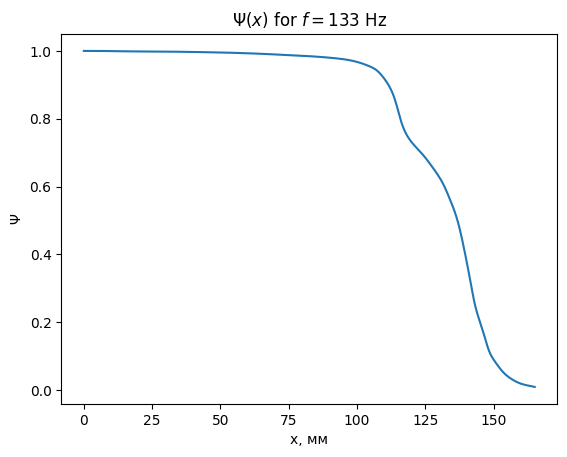

In [47]:
ODEIOSettings.info = print
N = 1000

# (S(x)y')' + lb*S(x)y = 0
# y'(0) = 0, c1*y'(L) + c0*y(L) = 0
# returns lb, y_n
def solve_by_augmented_vector_method(S : RtoR, c1 : float, c0 : float, N: int, L : float, initial_lambda : float) -> tuple[float, list[float]]:
    u = Vector([0, 0, 1] + [0] * (N - 2) + [initial_lambda])
    h = L / N
    def get_F_at(n : int, u : Vector):
        return S((n + 0.5)*h)*(u[n+1] - u[n]) + S((n - 0.5)*h)*(u[n-1] - u[n]) + u[-1]*h*h*S(n*h)*u[n]
    while True:
        ODEIOSettings.info("lb = " + str(u[-1]))
        F = Vector([4*u[1] - 3*u[0] - u[2]] + [get_F_at(n, u) for n in range(1, N)] + [c1*(3*u[N] - 4*u[N-1] + u[N-2]) + 2*h*c0*u[N]])
        b = Vector([h*h*S(h)/S(3/2*h)] + [h*h*S(n*h)*u[n] for n in range(1, N)] + [-h*h*S((N-1)*h)/S((N-3/2)*h)])
        A = [0] + [S((n - 0.5)*h) for n in range(1, N)] + [-4*c1]
        B = [-3] + [u[-1]*h*h*S(n*h) - S((n - 0.5)*h) - S((n + 0.5)*h) for n in range(1, N)] + [3*c1 + 2*h*c0]
        C = [4] + [S((n + 0.5)*h) for n in range(1, N)]
        f0 = 1/S(3/2*h)
        B[0] -= f0 * A[1]
        C[0] -= f0 * B[1]
        fN = c1/S((N-3/2)*h)
        A[-1] -= fN * B[-2]
        B[-1] -= fN * C[-2]
        p = LinearSolver.solve_tridiagonal(A, B, C, -F)
        q = LinearSolver.solve_tridiagonal(A, B, C, -b)
        lb = (1 - u[2] - p[2]) / q[2]
        du = Matrix((p + lb*q).data + [[lb]])
        u += du
        if NonlinearSolver.norm(du) < NonlinearSolver.eps:
            break
    return u[N + 1], Vector(u).toList()[:-1]

show_result(N, solve_by_augmented_vector_method(S, 8*sqrt(S(L)), 3*pi*sqrt(pi), N, L, 0), L)

